# T1 de NoIA

Neste trabalho, vamos aprender a implementar o algoritmo de redes neurais de aprendizado de máquina (ANN) para a tarefa de classificação de imagens de maneira mais eficiente. Vamos passar pelas várias técnicas de implementação que foram utilizadas ao longo do desenvolvimento e a evolução da tecnologia.

## Importações

Neste trabalho, utilizaremos a biblioteca [d2l](https://github.com/d2l-ai/d2l-en) para implementar o algoritmo de redes neurais. A biblioteca d2l é uma biblioteca de aprendizado de máquina de alto nível, desenvolvida pela DeepMind. Ela fornece uma interface amigável para a implementação de modelos de redes neurais, incluindo o uso de GPUs para acelerar o processo de treinamento.
Nos também utilizaremos a biblioteca tensorflow para fornecer as funções de redes neurais, matplotlib para visualizar os resultados, sklearn para realizar o treinamento e validação dos modelos, e pdb para depurar o código.

In [38]:
import tensorflow as tf
from d2l import tensorflow as d2l
d2l.use_svg_display()
import pdb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import statistics

## Base de dados

A base de dados é um conjunto de dados de treinamento e teste que serão utilizados para treinar e avaliar o modelo. Neste caso, vamos utilizar o conjunto de dados de teste do MNIST, que é um conjunto de imagens de tamanho 28x28 e de número de classes 10.

In [39]:
class MNIST(d2l.DataModule): #@save
    """The MNIST dataset."""
    def __init__(self, batch_size=64):
        super().__init__()
        self.save_hyperparameters()
        self.train, self.val = tf.keras.datasets.mnist.load_data()

In [40]:
data = MNIST()
print(len(data.train[0]), len(data.val[0]))
print(data.train[0].shape)

60000 10000
(60000, 28, 28)


Para podermos usar o d2l para o treinamento temos que definir o dataloader que divide o dataset em batchs e o modelo que irá receber os dados e fazer a predição.

In [41]:
@d2l.add_to_class(MNIST) #@save
def get_dataloader(self, train):
    data = self.train if train else self.val
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255, tf.cast(y, dtype='int32'))
    self.resize_fn = lambda X, y: (tf.image.resize_with_pad(X, *self.resize), y)
    shuffle_buf = len(data[0]) if train else 1
    return tf.data.Dataset.from_tensor_slices(process(*data)).batch(self.batch_size).shuffle(shuffle_buf)

In [42]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

(64, 28, 28, 1) <dtype: 'float32'> (64,) <dtype: 'int32'>


## Modelo básico perceptron

Aqui definimos a nossa primeira versão do modelo perceptron. O modelo perceptron é um modelo de classificação simples que é capaz de classificar dados de entrada em uma classe de saída. Neste caso é um modelo bem simples, com uma camada que transforma a matrix da entrada em um vetor (flatten), uma camada oculta e uma camada de saída, ambas usando a função sigmoide.

In [43]:
class MLPSigmoid(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='sigmoid'),
            tf.keras.layers.Dense(num_outputs, activation='sigmoid')])
        self.loss_fn=tf.keras.losses.MeanSquaredError
        self.optimizer=tf.keras.optimizers.SGD

Para podermos ter resultados o mais precisos, vamos realizar o treino 5 vezes e usar a média dos resultados para definirmos o erro médio do modelo usado.

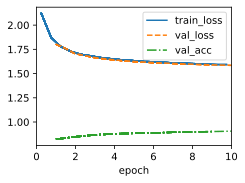

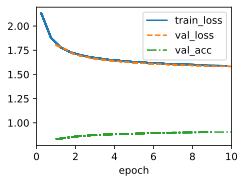

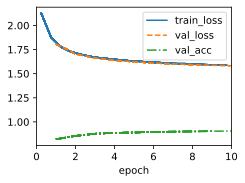

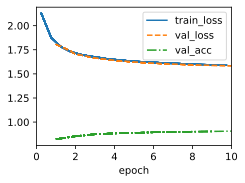

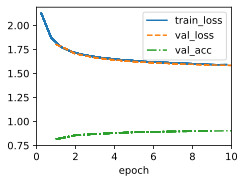

In [44]:
sigmoids_accuracy = []
for i in range(5):
    model = MLPSigmoid(num_outputs=10, num_hiddens=128, lr=0.1)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    sigmoids_accuracy.append(d2l.evaluate_accuracy(model, data.val_dataloader()))

In [45]:
print(f"Precisão dos 5 modelos: {sigmoids_accuracy}")
print(f"Precisão média dos 5 modelos {statistics.mean(sigmoids_accuracy)}")

Precisão dos 5 modelos: [0.9051, 0.9053, 0.9047, 0.9059, 0.9028]
Precisão média dos 5 modelos 0.90476


## Perceptron com saída softmax

O nosso próximo modelo será um perceptron com uma saída softmax. Como mudamos a saída para o resultado esperado, e não uma saída "one-hot", também mudamos o erro para o modelo de entropia cruzada.

In [46]:
class MLPSoftMax(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='sigmoid'),
            tf.keras.layers.Dense(num_outputs, activation='softmax')])
        self.loss_fn=tf.keras.losses.SparseCategoricalCrossentropy
        self.optimizer=tf.keras.optimizers.SGD

Novamente, vamos rodar o modelo 5 vezes para conseguirmos a acurácia média.

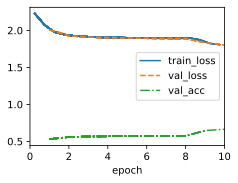

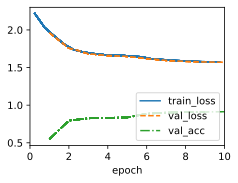

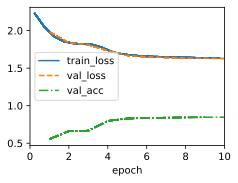

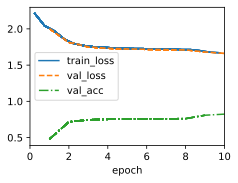

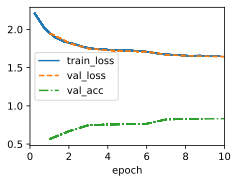

In [47]:
softmax_accuracy = []
for i in range(5):
    model = MLPSoftMax(num_outputs=10, num_hiddens=128, lr=0.1)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    softmax_accuracy.append(d2l.evaluate_accuracy(model, data.val_dataloader()))

In [48]:
print(f"Precisão dos 5 modelos: {softmax_accuracy}")
print(f"Precisão média dos 5 modelos {statistics.mean(softmax_accuracy)}")

Precisão dos 5 modelos: [0.664, 0.9128, 0.8467, 0.8238, 0.8325]
Precisão média dos 5 modelos 0.81596


## Otimizador Adam

Com o desenvolvimento dos modelos de machine learning, diferentes propostas de otimizadores de gradiente foram desenvolvidas. Uma das mais famosas é o otimizador Adam, que é uma extensão do otimizador SGD (Stochastic Gradient Descent). O SGD é um otimizador de gradiente que atualiza os pesos da rede de forma a minimizar a função de perda. O Adam é um otimizador que atualiza os pesos da rede de forma a minimizar a função de perda, mas com uma variação na atualização dos pesos.

In [49]:
class MLPAdam(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='sigmoid'),
            tf.keras.layers.Dense(num_outputs, activation='softmax')])
        self.loss_fn=tf.keras.losses.SparseCategoricalCrossentropy
        self.optimizer=tf.keras.optimizers.Adam

Novamente, para certificar a acurácia do modelo, vamos treiná-lo 5 vezes, e calcular a média de acurácia.

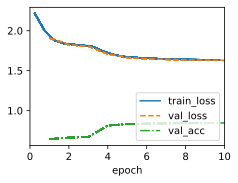

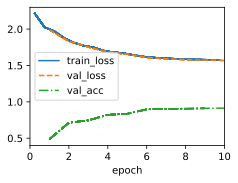

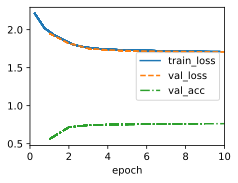

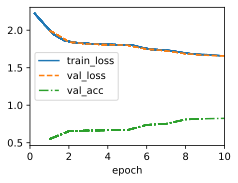

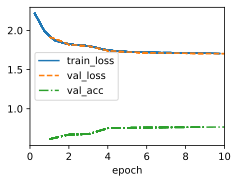

In [50]:
adam_accuracy = []
for i in range(5):
    model = MLPAdam(num_outputs=10, num_hiddens=128, lr=0.1)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    adam_accuracy.append(d2l.evaluate_accuracy(model, data.val_dataloader()))

In [51]:
print(f"Precisão dos 5 modelos: {adam_accuracy}")
print(f"Precisão média dos 5 modelos {statistics.mean(adam_accuracy)}")

Precisão dos 5 modelos: [0.8465, 0.9134, 0.7634, 0.825, 0.7661]
Precisão média dos 5 modelos 0.82288


## Função Relu

Um desenvolvimento inesperado, mas que é muito interessante, é a função relu. A função relu é uma função que recebe um valor e retorna o mesmo valor se ele for positivo ou zero se ele for negativo. E ela já da não linearidade o suficiente para ser usada como uma função de ativação.

In [52]:
class MLPRelu(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='relu'),
            tf.keras.layers.Dense(num_outputs, activation='softmax')])
        self.loss_fn=tf.keras.losses.SparseCategoricalCrossentropy
        self.optimizer=tf.keras.optimizers.Adam

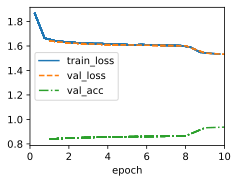

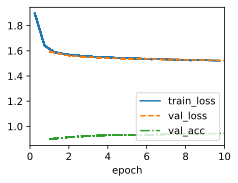

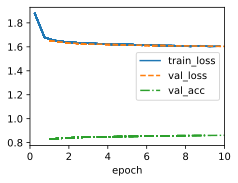

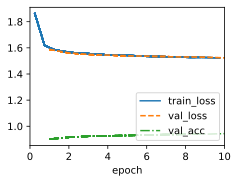

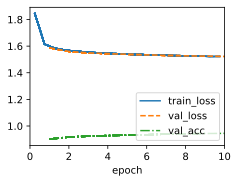

In [53]:
relu_accuracy = []
for i in range(5):
    model = MLPRelu(num_outputs=10, num_hiddens=128, lr=0.1)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    relu_accuracy.append(d2l.evaluate_accuracy(model, data.val_dataloader()))

In [54]:
print(f"Precisão dos 5 modelos: {relu_accuracy}")
print(f"Precisão média dos 5 modelos {statistics.mean(relu_accuracy)}")

Precisão dos 5 modelos: [0.9368, 0.9442, 0.8606, 0.9432, 0.9446]
Precisão média dos 5 modelos 0.92588


## Rede com 256 neurônios escondidos

Agora que aplicamos vários modelos que diminuem o tempo de treinamento, vamos tentar uma implementação mais eficaz. Vamos usar o modelo MLP com 256 neurônios escondidos.

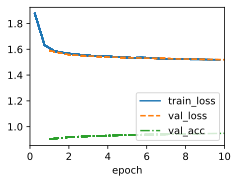

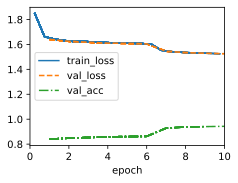

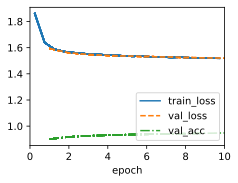

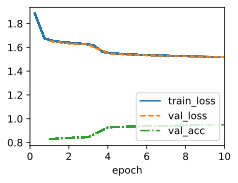

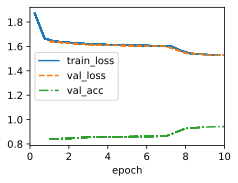

In [65]:
relu256_accuracy = []
for i in range(5):
    model = MLPRelu(num_outputs=10, num_hiddens=256, lr=0.1)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    relu256_accuracy.append(d2l.evaluate_accuracy(model, data.val_dataloader()))

In [66]:
print(f"Precisão dos 5 modelos: {relu256_accuracy}")
print(f"Precisão média dos 5 modelos {statistics.mean(relu256_accuracy)}")

Precisão dos 5 modelos: [0.9479, 0.9428, 0.9477, 0.9483, 0.9425]
Precisão média dos 5 modelos 0.94584


## Rede com 2 camadas escondidas

Além de podermos tornar a camada escondida maior, com o tempo de processamento que poupamos nos também possibilitamos a inserção de múltiplas camadas escondidas.

In [57]:
class MLPRelu2Hidden(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='relu'),
            tf.keras.layers.Dense(num_hiddens, activation='relu'),
            tf.keras.layers.Dense(num_outputs, activation='softmax')])
        self.loss_fn=tf.keras.losses.SparseCategoricalCrossentropy
        self.optimizer=tf.keras.optimizers.Adam

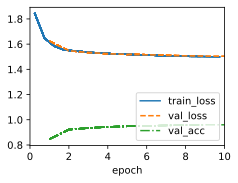

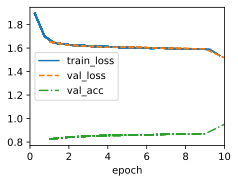

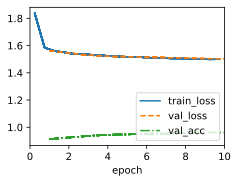

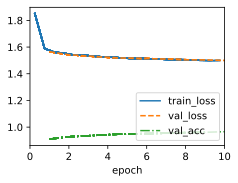

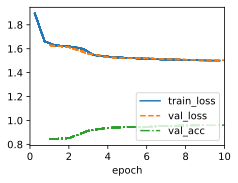

In [67]:
relu2_hidden_accuracy = []
for i in range(5):
    model = MLPRelu2Hidden(num_outputs=10, num_hiddens=256, lr=0.1)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    relu2_hidden_accuracy.append(d2l.evaluate_accuracy(model, data.val_dataloader()))

In [68]:
print(f"Precisão dos 5 modelos: {relu2_hidden_accuracy}")
print(f"Precisão média dos 5 modelos {statistics.mean(relu2_hidden_accuracy)}")

Precisão dos 5 modelos: [0.9597, 0.9515, 0.961, 0.9655, 0.9605]
Precisão média dos 5 modelos 0.95964
